<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EDA" data-toc-modified-id="EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Insights" data-toc-modified-id="Insights-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Insights</a></span></li></ul></div>

# EDA

In [1]:
# import modules
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
from statistics import mean 
plt.style.use('seaborn')

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

%matplotlib inline

In [2]:
#load data
file = 'data/salary.csv'
df = pd.read_csv(file)

In [3]:
def data_exp():
    """explore dataset"""
    profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
    return profile.to_widgets()

data_exp()

build report structure: 100%|██████████| 1/1 [00:11<00:00, 11.47s/it]


> Data comprises of 514 observations, with one missing value from the target variable (**salary**). Furthermore the data has 0% of duplicate rows. Some features are characterized by a high frequency of extreme values, case in point: **experior** and **yearsabs**. 

> A distinct linear relationship exists between **salary** and (**yearsrank**, **yearsworked** & **market**). The **Pearson's r** correlation matrix indicates that a moderately strong positive linear correlation exists between **salary** and **position**, while a moderately strong negative linear correlation is true for **salary** and **Field**.

> Lastly, other features such as **yearsabs**, **male**, and **yearsworked**, depict very strong linear correlations with other independent features, this may result in a multicollinearity problem when running a multiple linear regression model.

# Data Cleaning

In [4]:
# replace the missing value with the mean
df['salary'] = df.fillna(df['salary'].mean())

# detecting extreme values using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# removing outliers from the dataset
df_new = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    

# Feature Engineering

In [5]:
cat_columns = ["Field", "position"]
df_processed = pd.get_dummies(df_new, prefix_sep="_", columns=cat_columns, drop_first=False)


In [6]:
df_processed.rename(columns={'Field_1': 'Engineering', 'Field_2': 'Finance', 'Field_3':'Human Resources', 'Field_4':'Marketing'}, inplace=True)
df_processed.rename(columns={'position_1': 'Junior_Employee', 'position_2': 'Manager', 'position_3':'Executive'}, inplace=True)


In [7]:
del df_processed["Human Resources"]
del df_processed["Executive"]


# Model Training

In [8]:
# split data
train, test = train_test_split(df_processed, test_size=0.2, random_state=42)

In [9]:
# run model 
salary_model = ols("salary ~ Engineering + Junior_Employee + yearsrank + Finance + market + Manager", data=train).fit()
salary_model_2 = ols("salary ~ Engineering + Junior_Employee + Finance + market + Manager", data=train).fit()

print(salary_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     183.4
Date:                Thu, 07 May 2020   Prob (F-statistic):           3.94e-89
Time:                        16:31:41   Log-Likelihood:                -2586.3
No. Observations:                 260   AIC:                             5187.
Df Residuals:                     253   BIC:                             5212.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.888e+04   2289.613     

In [10]:
# Interprete coefficients
salary_model.params

Intercept          18883.808652
Engineering         5623.776753
Junior_Employee   -12871.811482
yearsrank            670.831013
Finance             4147.234995
market             32378.296216
Manager            -7598.705080
dtype: float64

> Holding all other factors constant, being a Junior Employee and a Manager is associated with a 12 871.81, as well as a 7 598.71 less salary respectively(as compared to a baseline salary of an Executive). 

> Similarly, working in the fields of Engineering and Finance is associated with a salary boost of 5 623.78 and 4 147.23 respectively (as compared to the baseline salary of workers in the field of Human Resources).

> **market** and **yearsrank** are distinguishable features, in the sense that one is the largest contributing feature in the prediction of the target, and the other is the least. 

> Thus, holding all other variables constant, we can assert that one year increase of an employee's number of years worked at current rank, tends to be associated with an average increase of 670.83 in salary. Similarly, one unit increase of the market value of a position tends to increase salary by an average of 32 378.30.

> All coefficients are significant at a 95% confidence interval, thus failing to reject the null hypothesis - the conclusion is that there is a relationship between selected features and target variable. Certain features like **yearsworked** and **Marketing** were excluded from the model because they were statistically insignificant, while other features like **yearsabs** and **degree** were excluded because they had very weak or no linear correlation with the target.

> Overall, approximately 80% of variance in the observed data can be explained by the model - check the the Adjusted R-squared.

In [11]:
#train data
y_train = train.salary
X_train = train[['yearsrank', 'Engineering', 'Finance', 'Manager', 'market']]
X_train_2 = train[['Engineering', 'Finance', 'Manager', 'market']]


#test data
y_test = test.salary
X_test = test[['yearsrank', 'Engineering', 'Finance', 'Manager', 'market']]
X_test_2 = test[['Engineering', 'Finance', 'Manager', 'market']]


# Instantiate model
lm1 = LinearRegression()
lm2 = LinearRegression()


# Fit model
lm1.fit(X_train, y_train)
lm2.fit(X_train_2, y_train)

# Predict
y_pred_train = lm1.predict(X_train)
y_pred_train_2 = lm2.predict(X_train_2)


# Fit model
lm1.fit(X_test, y_test)
lm2.fit(X_test_2, y_test)


# Predict
y_pred_test = lm1.predict(X_test)
y_pred_test_2 = lm2.predict(X_test_2)


MIN_resid:  -10911.17 MAX_resid:  19914.38 MEAN_resid:  0.0
 MIN_std_resid:  -2.16 MAX_std_resid:  3.94 MEAN_std_resid:  0.0
 MSE_train:  43042818.65 MSE_test:  44257334.04
 RMSE_train:  6560.7 RMSE_test:  6652.62


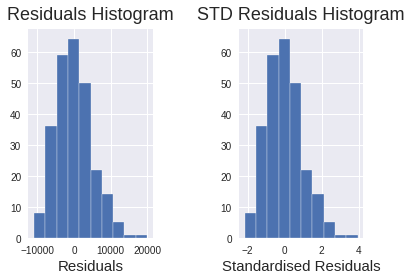

In [13]:
from src.ErrorCalculator import ErrorCalculator
from src.Plotter import Plotter

        
model_1 = ErrorCalculator(y_train, y_pred_train, salary_model, y_test, y_pred_test)
model_2 = ErrorCalculator(y_train, y_pred_train_2, salary_model_2, y_test, y_pred_test_2)

print(ErrorCalculator.error_summary(model_1))


        
model_1 = Plotter(y_train, y_pred_train, salary_model)
# model_2 = Plotter(y_train, y_pred_train_2, salary_model_2)

Plotter.plot_hist(model_1)
      
# class ScatterPlotter(Plotter):
#     def __init__(self, y, y_pred, result, dataset):
#         super().__init__(y, y_pred, result)
#         self.dataset = dataset
    
#     def resid_fitted_scatter(self):
#         residuals = self.result.resid
#         plt.subplot(211)
#         sns.residplot(self.y_pred, residuals, lowess=True, data=self.dataset, 
#              scatter_kws={'alpha':0.5},
#              line_kws={'color':'red', 'lw':1, 'alpha':0.8})
#         _ = plt.title("Residuals vs Predicted Values")
#         _ = plt.xlabel("Predicted")
#         _ = plt.ylabel("Residuals")
#         plt.show()
        
#         plt.subplot(212)
#         sns.residplot(self.y_pred, self.y, lowess=True, data=self.dataset, 
#              scatter_kws={'alpha':0.5},
#              line_kws={'color':'red', 'lw':1, 'alpha':0.8})
#         _ = plt.title("Predicted Values vs Observed Values")
#         _ = plt.xlabel("Predicted")
#         _ = plt.ylabel("Residuals")
#         plt.show()
        
# model_1 = ScatterPlotter(y_train, y_pred_train, salary_model, train)
# model_2 = ScatterPlotter(y_train, y_pred_train_2, salary_model_2, train)
      
# ScatterPlotter.resid_fitted_scatter(model_1)

# Insights

> The RMSE results of both **model_1** and **model_2** show that the model is underfitted. In the case of model_2, which is fitted with the exlusion of the **yearsrank** feature, the underfitting is execerbated. The residual plots satisfy the linear regression assumptions of linearity and homoscedasticity, however model_1 seems to be the better of the two. 